In [ ]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")
from sklearn.mixture import GaussianMixture
import os
import ot
import pickle
import argparse
import Levenshtein
import itertools
from helper_functions import *

inputdir = "/media/hieunguyen/HNHD01/raw_data/MRD_GW_v1_20250318/Metadata_Genome-wide_Version1_07.03.25"

PROJECT = "gs-mrd"
release_version = "20250319"

##### configurations/paths
path_to_main_src = "/media/hieunguyen/HNSD01/src/gs-mrd/v0.2"
path_to_model_files = f"{path_to_main_src}/model_files/{release_version}"
path_to_save_features = f"{path_to_main_src}/model_files/{release_version}/features"
path_to_save_feature_order = f"{path_to_main_src}/model_files/{release_version}/feature_order"

os.system(f"mkdir -p {path_to_save_features}")
os.system(f"mkdir -p {path_to_model_files}")
os.system(f"mkdir -p {path_to_save_feature_order}")

metadata_not_use = pd.read_excel(os.path.join(inputdir, "Metadata_Genome-wide Version1_07.03.25.xlsx"))
metadata = pd.read_csv(os.path.join(inputdir, "meta_full.csv"))

all_train_samples = metadata[metadata["Set"] == "train"]["SampleID"].unique()
all_test_samples = metadata[metadata["Set"] == "test"]["SampleID"].unique()
all_validate_samples = metadata[metadata["Set"] == "validate"]["SampleID"].unique()

##### generate sample list for each class, all samples
samplelist = dict()
for label in metadata.Cancer.unique():
    samplelist[label] = metadata[metadata["Cancer"] == label]["SampleID"].to_list()

##### generate sample list for each class, train samples only
train_samplelist = dict()
for label in metadata.Cancer.unique():
    train_samplelist[label] = metadata[(metadata["Cancer"] == label) & (metadata["Set"] == "train")]["SampleID"].to_list()
    
##### generate sample list for each class, test samples only
test_samplelist = dict()
for label in metadata.Cancer.unique():
    test_samplelist[label] = metadata[(metadata["Cancer"] == label) & (metadata["Set"] == "test")]["SampleID"].to_list()

##### generate sample list for each class, validate samples only
validate_samplelist = dict()
for label in metadata.Cancer.unique():
    validate_samplelist[label] = metadata[(metadata["Cancer"] == label) & (metadata["Set"] == "validate")]["SampleID"].to_list()

##### read features in
featuredf = dict()
train_featuredf = dict()
test_featuredf = dict()
validate_featuredf = dict()

for f in ["NUCLEOSOME", "FLEN", "EM", "IchorCNA"]:
    featuredf[f] = pd.read_csv(os.path.join(inputdir, f"{f}.csv"))

featuredf["IchorCNA"].columns = ["SampleID", "ichorCNA"]

for f in ["NUCLEOSOME", "FLEN", "EM", "IchorCNA"]:
    train_featuredf[f] = featuredf[f][featuredf[f]["SampleID"].isin(all_train_samples)]
    test_featuredf[f] = featuredf[f][featuredf[f]["SampleID"].isin(all_test_samples)]
    validate_featuredf[f] = featuredf[f][featuredf[f]["SampleID"].isin(all_validate_samples)]

train_featuredf["IchorCNA"].columns = ["SampleID", "ichorCNA"]
test_featuredf["IchorCNA"].columns = ["SampleID", "ichorCNA"]
validate_featuredf["IchorCNA"].columns = ["SampleID", "ichorCNA"]

##### distance matrix based on edit distance of End motif 4bp
nucleotides = ['A', 'C', 'G', 'T']
motifs = [''.join(p) for p in itertools.product(nucleotides, repeat=4)]

# Initialize an empty distance matrix
distance_matrix = pd.DataFrame(index=motifs, columns=motifs)

# Compute the Levenshtein distance between each pair of 4-mer motifs
for motif1 in motifs:
    for motif2 in motifs:
        distance_matrix.loc[motif1, motif2] = Levenshtein.distance(motif1, motif2)

# Convert the distance matrix to integer type
M_EM = distance_matrix.to_numpy().copy()
M_EM /= M_EM.max() * 0.1

train_features = dict() 

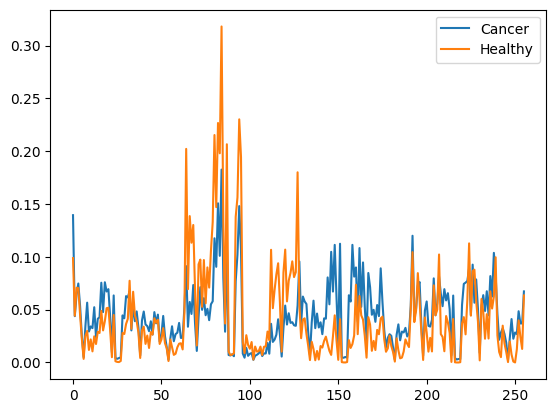

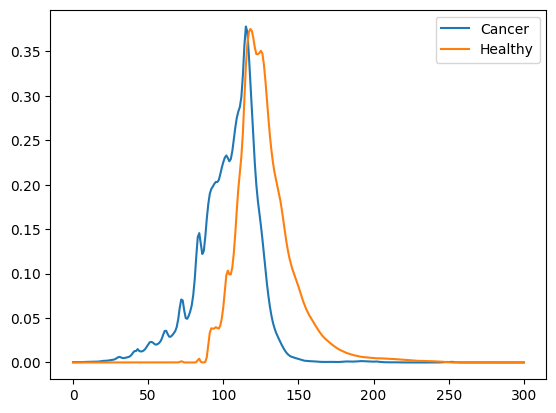

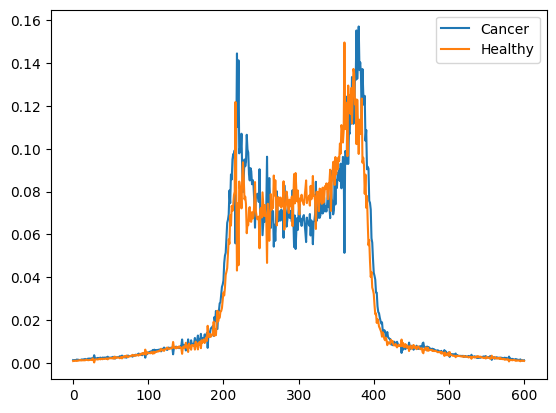

In [3]:

train_features = dict() 

for input_feature in ["EM", "FLEN", "NUCLEOSOME"]:
    ##### generate average FEATURE in all control samples in this batch
    inputdf = train_featuredf[input_feature].copy().set_index("SampleID").T
    inputdf["Healthy"] = inputdf[train_samplelist["Healthy"]].mean(axis = 1)
    inputdf[["Healthy"]].to_csv(f"{path_to_model_files}/Healthy_reference_{input_feature}.csv")
    inputdf = inputdf.drop("Healthy", axis = 1)
    
    ##### calculate OT barycenters
    if input_feature == "EM":
        baryl2 = calculate_barycenter(inputdf = train_featuredf[input_feature].set_index("SampleID").T,
                                      samplelist = train_samplelist, 
                                      n = inputdf.shape[0], show_plot=False, M = M_EM)
    else: 
        baryl2 = calculate_barycenter(inputdf = train_featuredf[input_feature].set_index("SampleID").T,
                                      samplelist = train_samplelist, 
                                      n = inputdf.shape[0], show_plot=False, M = None)
    pd.DataFrame(data = baryl2, columns = ["baryl2"]).to_csv(f"{path_to_model_files}/Healthy_OT_{input_feature}_baryl2.csv", index = False)
    
    ##### NMF models
    X = train_featuredf[input_feature].set_index("SampleID")
    model = NMF(n_components=2, init='random', random_state=0, solver = "mu")
    W = model.fit_transform(X.to_numpy())
    H = model.components_
    nmfdf = pd.DataFrame(data = W, columns = ["V1", "V2"])
    nmfdf["SampleID"] = list(X.index)
    nmfdf["V1_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[0]/sum(x), axis = 1)
    nmfdf["V2_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[1]/sum(x), axis = 1)
    nmfdf = nmfdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    sns.lineplot(H[0, ], label = "Cancer")
    sns.lineplot(H[1, ], label = "Healthy")
    plt.legend()
    plt.show()

    signal1 = [i for i,j in enumerate(H[0, ]) if j == np.max(H[0, ])][0]
    signal2 = [i for i,j in enumerate(H[1, ]) if j == np.max(H[1, ])][0]

    if (signal1 < signal2):
        nmf_signal_cancer = 1
    else:
        nmf_signal_cancer = 2
    pd.DataFrame(data = [nmf_signal_cancer], columns = ["nmf_signal_cancer"]).to_csv(f"{path_to_model_files}/NMF_{input_feature}_cancer_signal.csv")
    filename = os.path.join(path_to_model_files, f'NMF_{input_feature}.sav')
    pickle.dump(model, open(filename, 'wb'))
    
    tmpdf = nmfdf[["SampleID", f"V{nmf_signal_cancer}_scale"]].copy()
    tmpdf.columns = ["SampleID", f"NMF_{input_feature}_{nmf_signal_cancer}"]
    train_features[f"NMF_{input_feature}_{nmf_signal_cancer}"] = tmpdf.copy()

# Main analysis


## save sample order and feature order

In [15]:
for f in train_featuredf.keys():
    train_featuredf[f].to_csv(f"{path_to_save_feature_order}/train_{f}.csv", index = False)        
    test_featuredf[f].to_csv(f"{path_to_save_feature_order}/test_{f}.csv", index = False)        
    validate_featuredf[f].to_csv(f"{path_to_save_feature_order}/validate_{f}.csv", index = False)        


NameError: name 'path_to_save_feature_order' is not defined

## Generate cut-off for this analysis

In [4]:
#####--------------------------------------------------------------#####
##### Generate cut-off for this release
#####--------------------------------------------------------------#####

##### absolute difference between a sample and the reference
# prepare references
ref = dict()

em_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_EM.csv")
em_ref.columns = ["motif", "Healthy"]
ref["EM"] = em_ref.copy()

flen_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_FLEN.csv")
flen_ref.columns = ["FLEN", "Healthy"]
ref["FLEN"] = flen_ref.copy()

nuc_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_NUCLEOSOME.csv")
nuc_ref.columns = ["Nucleosome", "Healthy"]
ref["NUCLEOSOME"] = nuc_ref.copy()



## Apply to train dataset

In [5]:
all_samples = train_featuredf["FLEN"].SampleID.unique()

# add score EM, FLEN, NUCLEOSOME to train_features
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    inputdf = train_featuredf[f].set_index("SampleID").T.copy()
    inputdf["Healthy"] = ref[f]["Healthy"].values
    for sampleid in all_samples:
        inputdf[sampleid] = abs(inputdf[sampleid] - inputdf["Healthy"])
    input_scoredf = inputdf.drop("Healthy", axis = 1).sum().reset_index()
    input_scoredf.columns = ["SampleID", f"{f}_score"]
    input_scoredf = input_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    train_features[f"{f}_score"] = input_scoredf

# add Shannon entropy for EM feature
f = "EM"
inputdf = train_featuredf[f].set_index("SampleID").T

em_shannondf = pd.DataFrame(data = inputdf.columns, columns = ["SampleID"])
def calculate_em_shannon(x, inputdf):
    tmpdf = inputdf[x].values
    shannon = -np.sum([item * np.log2(item) for item in tmpdf])/256
    return(shannon)
em_shannondf["EM_shannon"] = em_shannondf["SampleID"].apply(lambda x: calculate_em_shannon(x, inputdf))
em_shannondf = em_shannondf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
train_features["EM_shannon"] = em_shannondf

##### OT distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    barycenter = pd.read_csv(f"{path_to_model_files}/Healthy_OT_{f}_baryl2.csv")
    bary_l2 = barycenter.baryl2.to_numpy()
    ot_scoredf = pd.DataFrame(data = all_samples, columns = ["SampleID"])
    ot_scoredf[f"OT_{f}"] = ot_scoredf["SampleID"].apply(lambda x: 
        calculate_ot_distance_to_healthy_nuc(x, 
                                             bary_l2, 
                                             train_featuredf[f].set_index("SampleID").T, 
                                             n = train_featuredf[f].shape[1] - 1))
    ot_scoredf = ot_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    train_features[f"OT_{f}"] = ot_scoredf
    
train_features["ichorCNA"] = train_featuredf["IchorCNA"]
train_outputdf = pd.DataFrame(data = metadata["SampleID"].to_list(), columns = ["SampleID"])
for feat in train_features.keys():
    tmpdf = train_features[feat][["SampleID", feat]]
    tmpdf.columns = ["SampleID", feat]
    train_outputdf = train_outputdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")

train_outputdf = train_outputdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")

cutoffdf = train_outputdf[train_outputdf["SampleID"].isin(samplelist["Healthy"])][ ["SampleID"] + list(train_features.keys())].set_index("SampleID").max().reset_index()
cutoffdf.columns = ["feature", "cutoff"]
cutoffdf.to_csv(f"{path_to_model_files}/cutoff.csv", index = False)

train_outputdf["True_label"] = train_outputdf[["Cancer", "Label"]].apply(
    lambda x: x[1] if x[0] != "Healthy" else "Healthy", axis = 1
)

train_outputdf["Label"] = train_outputdf["Label"].apply(lambda x: 1 if x == "Pos" else 0)

In [6]:
from itertools import combinations
all_features = train_features.keys()
for feat in all_features:
    c = float(cutoffdf[cutoffdf["feature"] == feat].cutoff.values[0])
    train_outputdf[f"prediction_{feat}"] = train_outputdf[feat].apply(
        lambda x: 1 if x > c else 0
    )
train_outputdf = train_outputdf[train_outputdf["Label"] != "?"]
train_resdf = pd.DataFrame(data = all_features, columns = ["feature"])
train_resdf["SEN"] = train_resdf["feature"].apply(
    lambda x: train_outputdf[(train_outputdf[f"prediction_{x}"] == 1) & (train_outputdf["Label"] == 1)].shape[0]/train_outputdf[train_outputdf["Label"]== 1].shape[0]
)
train_resdf["SPEC"] = train_resdf["feature"].apply(
    lambda x: train_outputdf[(train_outputdf[f"prediction_{x}"] == 0) & (train_outputdf["Label"] == 0)].shape[0]/train_outputdf[train_outputdf["Label"]== 0].shape[0]
)
feature_combinations = []
for i in range(1, len(all_features) + 1):
    feature_combinations.extend(combinations(all_features, i))

train_combinedf = pd.DataFrame(data = [",".join(feature_combinations[i]) for i in range(len(feature_combinations))], columns = ["feature_combinations"])
def get_Sen_Spec_for_combi(combi, inputdf):
    input_feats = combi.split(",")
    tmpdf =  inputdf[["Label"] + [f"prediction_{i}" for i in input_feats]]
    tmpdf["sum"] = tmpdf[[f"prediction_{i}" for i in input_feats]].sum(axis = 1)
    tmpdf["prediction"] = tmpdf["sum"].apply(lambda x: 1 if x != 0 else 0)
    sen = tmpdf[(tmpdf["prediction"] == 1) & (tmpdf["Label"] == 1)].shape[0]/tmpdf[tmpdf["Label"]== 1].shape[0]
    spec = tmpdf[(tmpdf["prediction"] == 0) & (tmpdf["Label"] == 0)].shape[0]/tmpdf[tmpdf["Label"]== 0].shape[0]
    return(sen, spec)

train_combinedf[["SEN_Train", "SPEC_Train"]] = train_combinedf["feature_combinations"].apply(lambda x: get_Sen_Spec_for_combi(x, train_outputdf)).apply(pd.Series)


## Apply to test dataset

In [7]:
test_features = dict()

all_samples = test_featuredf["FLEN"].SampleID.unique()

# add score EM, FLEN, NUCLEOSOME to test_features
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    inputdf = test_featuredf[f].set_index("SampleID").T.copy()
    inputdf["Healthy"] = ref[f]["Healthy"].values
    for sampleid in all_samples:
        inputdf[sampleid] = abs(inputdf[sampleid] - inputdf["Healthy"])
    input_scoredf = inputdf.drop("Healthy", axis = 1).sum().reset_index()
    input_scoredf.columns = ["SampleID", f"{f}_score"]
    input_scoredf = input_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    test_features[f"{f}_score"] = input_scoredf

f = "EM"
inputdf = test_featuredf[f].set_index("SampleID").T

em_shannondf = pd.DataFrame(data = inputdf.columns, columns = ["SampleID"])
def calculate_em_shannon(x, inputdf):
    tmpdf = inputdf[x].values
    shannon = -np.sum([item * np.log2(item) for item in tmpdf])/256
    return(shannon)
em_shannondf["EM_shannon"] = em_shannondf["SampleID"].apply(lambda x: calculate_em_shannon(x, inputdf))
em_shannondf = em_shannondf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
test_features["EM_shannon"] = em_shannondf
##### OT distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    barycenter = pd.read_csv(f"{path_to_model_files}/Healthy_OT_{f}_baryl2.csv")
    bary_l2 = barycenter.baryl2.to_numpy()
    ot_scoredf = pd.DataFrame(data = all_samples, columns = ["SampleID"])
    ot_scoredf[f"OT_{f}"] = ot_scoredf["SampleID"].apply(lambda x: 
        calculate_ot_distance_to_healthy_nuc(x, 
                                             bary_l2, 
                                             test_featuredf[f].set_index("SampleID").T, 
                                             n = test_featuredf[f].shape[1] - 1))
    ot_scoredf = ot_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    test_features[f"OT_{f}"] = ot_scoredf
    
test_features["ichorCNA"] = test_featuredf["IchorCNA"]

for input_feature in ["EM", "FLEN", "NUCLEOSOME"]:
    filename = os.path.join(path_to_model_files, f'NMF_{input_feature}.sav')
    model = pickle.load(open(filename, 'rb'))
    X = test_featuredf[input_feature].set_index("SampleID")
    W = model.transform(X.to_numpy())
    H = model.components_
    nmf_signal_cancer = cutoffdf[cutoffdf["feature"].str.contains(input_feature)]["feature"].values[0].split("_")[2]
    nmfdf = pd.DataFrame(data = W, columns = ["V1", "V2"])
    nmfdf["SampleID"] = list(X.index)
    nmfdf["V1_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[0]/sum(x), axis = 1)
    nmfdf["V2_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[1]/sum(x), axis = 1)
    nmfdf = nmfdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    tmpdf = nmfdf[["SampleID", f"V{nmf_signal_cancer}_scale"]].copy()
    tmpdf.columns = ["SampleID", f"NMF_{input_feature}_{nmf_signal_cancer}"]
    test_features[f"NMF_{input_feature}_{nmf_signal_cancer}"] = tmpdf.copy()
test_outputdf = pd.DataFrame(data = metadata["SampleID"].to_list(), columns = ["SampleID"])
for feat in test_features.keys():
    tmpdf = test_features[feat][["SampleID", feat]]
    tmpdf.columns = ["SampleID", feat]
    test_outputdf = test_outputdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")

test_outputdf = test_outputdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")

test_outputdf["True_label"] = test_outputdf[["Cancer", "Label"]].apply(
    lambda x: x[1] if x[0] != "Healthy" else "Healthy", axis = 1
)

test_outputdf["Label"] = test_outputdf["Label"].apply(lambda x: 1 if x == "Pos" else 0)

In [8]:
all_features = test_features.keys()
for feat in all_features:
    c = float(cutoffdf[cutoffdf["feature"] == feat].cutoff.values[0])
    test_outputdf[f"prediction_{feat}"] = test_outputdf[feat].apply(
        lambda x: 1 if x > c else 0
    )
test_outputdf = test_outputdf[test_outputdf["Label"] != "?"]
train_resdf = pd.DataFrame(data = all_features, columns = ["feature"])
train_resdf["SEN"] = train_resdf["feature"].apply(
    lambda x: test_outputdf[(test_outputdf[f"prediction_{x}"] == 1) & (test_outputdf["Label"] == 1)].shape[0]/test_outputdf[test_outputdf["Label"]== 1].shape[0]
)
train_resdf["SPEC"] = train_resdf["feature"].apply(
    lambda x: test_outputdf[(test_outputdf[f"prediction_{x}"] == 0) & (test_outputdf["Label"] == 0)].shape[0]/test_outputdf[test_outputdf["Label"]== 0].shape[0]
)
feature_combinations = []
for i in range(1, len(all_features) + 1):
    feature_combinations.extend(combinations(all_features, i))

test_combinedf = pd.DataFrame(data = [",".join(feature_combinations[i]) for i in range(len(feature_combinations))], columns = ["feature_combinations"])

test_combinedf[["SEN_test", "SPEC_test"]] = test_combinedf["feature_combinations"].apply(lambda x: get_Sen_Spec_for_combi(x, test_outputdf)).apply(pd.Series)
test_combinedf

,feature_combinations,SEN_test,SPEC_test
0,EM_score,0.01,1.000000
1,FLEN_score,0.07,1.000000
2,NUCLEOSOME_score,0.05,1.000000
3,EM_shannon,0.23,1.000000
4,OT_EM,0.24,1.000000
...,...,...,...
2042,"EM_score,FLEN_score,NUCLEOSOME_score,OT_EM,OT_...",0.43,0.983333
2043,"EM_score,FLEN_score,EM_shannon,OT_EM,OT_FLEN,O...",0.47,0.983333
2044,"EM_score,NUCLEOSOME_score,EM_shannon,OT_EM,OT_...",0.47,0.983333
2045,"FLEN_score,NUCLEOSOME_score,EM_shannon,OT_EM,O...",0.47,0.983333


## Apply to validation dataset

In [9]:
validate_features = dict()

all_samples = validate_featuredf["FLEN"].SampleID.unique()

# add score EM, FLEN, NUCLEOSOME to validate_features
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    inputdf = validate_featuredf[f].set_index("SampleID").T.copy()
    inputdf["Healthy"] = ref[f]["Healthy"].values
    for sampleid in all_samples:
        inputdf[sampleid] = abs(inputdf[sampleid] - inputdf["Healthy"])
    input_scoredf = inputdf.drop("Healthy", axis = 1).sum().reset_index()
    input_scoredf.columns = ["SampleID", f"{f}_score"]
    input_scoredf = input_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    validate_features[f"{f}_score"] = input_scoredf

f = "EM"
inputdf = validate_featuredf[f].set_index("SampleID").T

em_shannondf = pd.DataFrame(data = inputdf.columns, columns = ["SampleID"])
def calculate_em_shannon(x, inputdf):
    tmpdf = inputdf[x].values
    shannon = -np.sum([item * np.log2(item) for item in tmpdf])/256
    return(shannon)
em_shannondf["EM_shannon"] = em_shannondf["SampleID"].apply(lambda x: calculate_em_shannon(x, inputdf))
em_shannondf = em_shannondf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
validate_features["EM_shannon"] = em_shannondf
##### OT distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    barycenter = pd.read_csv(f"{path_to_model_files}/Healthy_OT_{f}_baryl2.csv")
    bary_l2 = barycenter.baryl2.to_numpy()
    ot_scoredf = pd.DataFrame(data = all_samples, columns = ["SampleID"])
    ot_scoredf[f"OT_{f}"] = ot_scoredf["SampleID"].apply(lambda x: 
        calculate_ot_distance_to_healthy_nuc(x, 
                                             bary_l2, 
                                             validate_featuredf[f].set_index("SampleID").T, 
                                             n = validate_featuredf[f].shape[1] - 1))
    ot_scoredf = ot_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    validate_features[f"OT_{f}"] = ot_scoredf
    
validate_features["ichorCNA"] = validate_featuredf["IchorCNA"]

for input_feature in ["EM", "FLEN", "NUCLEOSOME"]:
    filename = os.path.join(path_to_model_files, f'NMF_{input_feature}.sav')
    model = pickle.load(open(filename, 'rb'))
    X = validate_featuredf[input_feature].set_index("SampleID")
    W = model.transform(X.to_numpy())
    H = model.components_
    nmf_signal_cancer = cutoffdf[cutoffdf["feature"].str.contains(input_feature)]["feature"].values[0].split("_")[2]
    nmfdf = pd.DataFrame(data = W, columns = ["V1", "V2"])
    nmfdf["SampleID"] = list(X.index)
    nmfdf["V1_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[0]/sum(x), axis = 1)
    nmfdf["V2_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[1]/sum(x), axis = 1)
    nmfdf = nmfdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    tmpdf = nmfdf[["SampleID", f"V{nmf_signal_cancer}_scale"]].copy()
    tmpdf.columns = ["SampleID", f"NMF_{input_feature}_{nmf_signal_cancer}"]
    validate_features[f"NMF_{input_feature}_{nmf_signal_cancer}"] = tmpdf.copy()
validate_outputdf = pd.DataFrame(data = metadata["SampleID"].to_list(), columns = ["SampleID"])
for feat in validate_features.keys():
    tmpdf = validate_features[feat][["SampleID", feat]]
    tmpdf.columns = ["SampleID", feat]
    validate_outputdf = validate_outputdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")

validate_outputdf = validate_outputdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")

validate_outputdf["True_label"] = validate_outputdf[["Cancer", "Label"]].apply(
    lambda x: x[1] if x[0] != "Healthy" else "Healthy", axis = 1
)

validate_outputdf["Label"] = validate_outputdf["Label"].apply(lambda x: 1 if x == "Pos" else 0)

In [10]:
all_features = validate_features.keys()
for feat in all_features:
    c = float(cutoffdf[cutoffdf["feature"] == feat].cutoff.values[0])
    validate_outputdf[f"prediction_{feat}"] = validate_outputdf[feat].apply(
        lambda x: 1 if x > c else 0
    )
validate_outputdf = validate_outputdf[validate_outputdf["Label"] != "?"]
train_resdf = pd.DataFrame(data = all_features, columns = ["feature"])
train_resdf["SEN"] = train_resdf["feature"].apply(
    lambda x: validate_outputdf[(validate_outputdf[f"prediction_{x}"] == 1) & (validate_outputdf["Label"] == 1)].shape[0]/validate_outputdf[validate_outputdf["Label"]== 1].shape[0]
)
train_resdf["SPEC"] = train_resdf["feature"].apply(
    lambda x: validate_outputdf[(validate_outputdf[f"prediction_{x}"] == 0) & (validate_outputdf["Label"] == 0)].shape[0]/validate_outputdf[validate_outputdf["Label"]== 0].shape[0]
)
feature_combinations = []
for i in range(1, len(all_features) + 1):
    feature_combinations.extend(combinations(all_features, i))

validate_combinedf = pd.DataFrame(data = [",".join(feature_combinations[i]) for i in range(len(feature_combinations))], columns = ["feature_combinations"])

validate_combinedf[["SEN_validate", "SPEC_validate"]] = validate_combinedf["feature_combinations"].apply(lambda x: get_Sen_Spec_for_combi(x, validate_outputdf)).apply(pd.Series)
validate_combinedf

,feature_combinations,SEN_validate,SPEC_validate
0,EM_score,0.018939,1.000000
1,FLEN_score,0.094697,1.000000
2,NUCLEOSOME_score,0.053030,1.000000
3,EM_shannon,0.185606,0.988722
4,OT_EM,0.151515,0.992481
...,...,...,...
2042,"EM_score,FLEN_score,NUCLEOSOME_score,OT_EM,OT_...",0.424242,0.969925
2043,"EM_score,FLEN_score,EM_shannon,OT_EM,OT_FLEN,O...",0.462121,0.962406
2044,"EM_score,NUCLEOSOME_score,EM_shannon,OT_EM,OT_...",0.462121,0.962406
2045,"FLEN_score,NUCLEOSOME_score,EM_shannon,OT_EM,O...",0.462121,0.962406


## summary all results in train - test - validation datasets

In [11]:
summarydf = train_combinedf.merge(test_combinedf, right_on = "feature_combinations", left_on = "feature_combinations")
summarydf = summarydf.merge(validate_combinedf, right_on = "feature_combinations", left_on = "feature_combinations")

summarydf

,feature_combinations,SEN_Train,SPEC_Train,SEN_test,SPEC_test,SEN_validate,SPEC_validate
0,NMF_EM_2,0.0275,1.0,0.02,1.000000,0.030303,1.000000
1,NMF_FLEN_1,0.3300,1.0,0.31,1.000000,0.291667,0.984962
2,NMF_NUCLEOSOME_2,0.2000,1.0,0.28,1.000000,0.272727,0.984962
3,EM_score,0.0100,1.0,0.01,1.000000,0.018939,1.000000
4,FLEN_score,0.0875,1.0,0.07,1.000000,0.094697,1.000000
...,...,...,...,...,...,...,...
257,"EM_score,FLEN_score,NUCLEOSOME_score,OT_EM,OT_...",0.2975,1.0,0.34,0.983333,0.295455,0.988722
258,"EM_score,FLEN_score,EM_shannon,OT_EM,OT_FLEN,O...",0.3675,1.0,0.39,0.983333,0.356061,0.977444
259,"EM_score,NUCLEOSOME_score,EM_shannon,OT_EM,OT_...",0.3650,1.0,0.39,0.983333,0.348485,0.977444
260,"FLEN_score,NUCLEOSOME_score,EM_shannon,OT_EM,O...",0.3675,1.0,0.39,0.983333,0.356061,0.977444
